---> Starting Full Workflow <---
Using WKT file data
1. Loading WKT data into gdf...
gdf GeoDataFrame loaded successfully.
2. Initializing Roads, Rivers...
Roads (head):


,geometry,road_id
0,"LINESTRING (7071.422 8585.628, 7074.673 8588.8...",R1
1,"LINESTRING (7228.943 8691.704, 7230.264 8692.302)",R2
2,"LINESTRING (7230.13 8690.91, 7236.636 8693.948...",R3
3,"LINESTRING (7233.052 8685.026, 7233.114 8684.901)",R4
4,"LINESTRING (7235.343 8681.163, 7235.952 8680.34)",R5


Rivers (head):


,geometry,river_id
15,"LINESTRING (7152.923 8639.584, 7153.401 8639.8...",RV1
16,"LINESTRING (7149.315 8641.775, 7151.011 8642.8...",RV2
17,"LINESTRING (7159.332 8627.201, 7160.009 8627.4...",RV3
18,"LINESTRING (7160.622 8627.965, 7161.134 8628.2...",RV4
19,"LINESTRING (7160.536 8626.61, 7160.009 8627.42...",RV5


Bridges (head):


,bridge_id,geometry
0,B1,"LINESTRING (4.8 5, 5.2 5)"



3. Running AI Logic for Missing Bridge Detection...
Total missing bridge errors found: 12
Roads: 15
Rivers: 39
Bridges: 1


,bridge_id,geometry
0,B1,"LINESTRING (4.8 5, 5.2 5)"



4. Generating Missing Bridge Detection Plot...


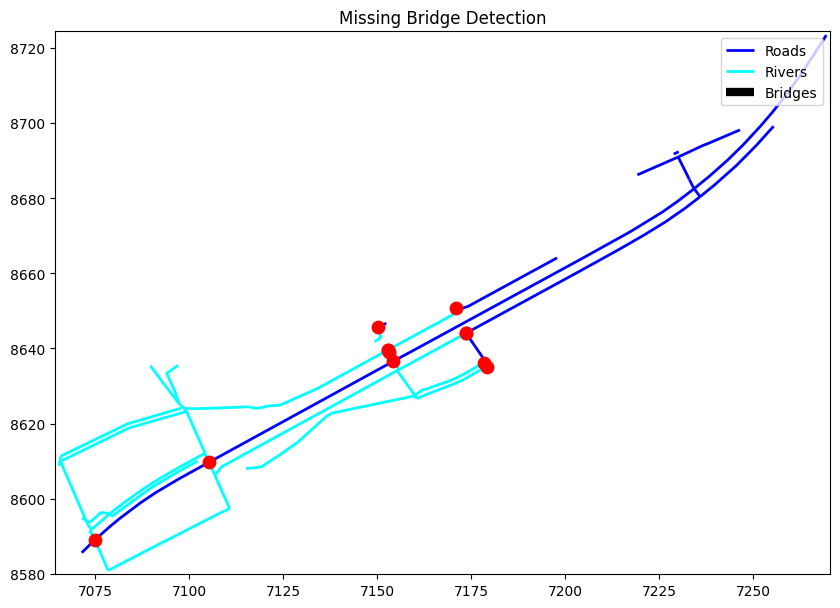


--- 5. Summary ---
Total Roads: 15
Total Rivers: 39
Total Bridges: 1
Errors Found: 12

6. Generating Error Report...
Error Report (df_report):


,Error Type,Road,River,X,Y,Confidence,Severity
0,Road crosses river without bridge,R1,RV6,7154.35,8636.57,0.92,High
1,Road crosses river without bridge,R1,RV25,7105.30,8609.70,0.92,High
2,Road crosses river without bridge,R1,RV37,7074.90,8589.03,0.92,High
3,Road crosses river without bridge,R10,RV1,7171.13,8650.78,0.92,High
4,Road crosses river without bridge,R11,RV2,7150.31,8645.72,0.92,High
5,Road crosses river without bridge,R12,RV4,7178.49,8636.17,0.92,High
6,Road crosses river without bridge,R13,RV7,7173.68,8644.05,0.92,High
7,Road crosses river without bridge,R14,RV7,7173.68,8644.05,0.92,High
8,Road crosses river without bridge,R14,RV9,7179.22,8635.07,0.92,High
9,Road crosses river without bridge,R15,RV1,7152.92,8639.58,0.92,High



7. Generating Detailed Visual Explanation...


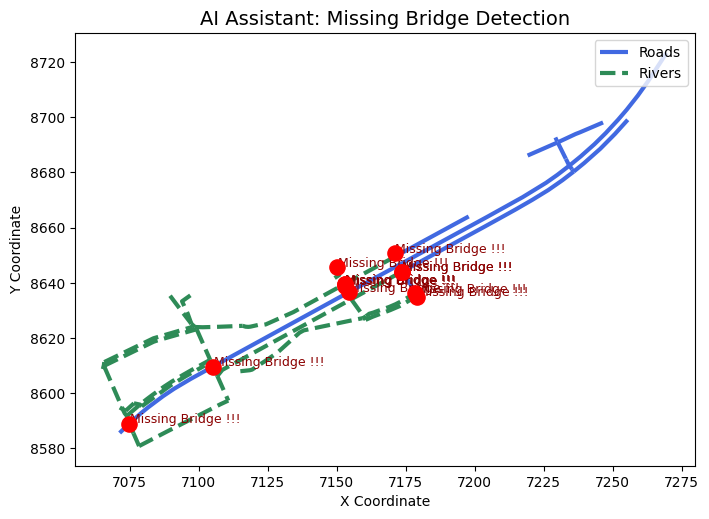

Detailed visualization saved as ai_mapping_error_output.png

8. Exporting Error Report to CSV...
Error report saved as mapping_error_report.csv
---> Full Workflow Completed <---


In [16]:
import geopandas as gpd
from shapely import wkt, LineString
import matplotlib.pyplot as plt
import pandas as pd

print("---> Starting Full Workflow <---")

# Manual Testing

MANUAL_TEST = False  # Change to True when you want to test manually
from shapely.geometry import LineString
import geopandas as gpd

if MANUAL_TEST:
    print("Manual testing mode enabled")

    # 👉 Enter your own road lines
    roads = gpd.GeoDataFrame({
        "road_id": ["R1"],
        "geometry": [
            LineString([(0,0), (10,10)])
        ]
    })

    # 👉 Enter your own river lines
    rivers = gpd.GeoDataFrame({
        "river_id": ["RV1"],
        "geometry": [
            LineString([(0,5), (10,5)])
        ]
    })

    # 👉 Enter bridges if they exist
    bridges = gpd.GeoDataFrame({
        "bridge_id": ["B1"],
        "geometry": [
            LineString ([(4.8,5),(5.2,5)])
        ]
    },geometry="geometry")

    print("Manual roads, rivers, bridges loaded")

else:
    print("Using WKT file data")

# --- 1. Load and Preprocess WKT Data into gdf ---
if not MANUAL_TEST:
    print("1. Loading WKT data into gdf...")

    with open('/content/Problem 2 - streets_xgen.wkt', 'r') as f:
        wkt_content = f.read()

    processed_wkt_lines = []
    current_line = ""

    for line in wkt_content.split('\n'):
        stripped_line = line.strip()
        if stripped_line.startswith('LINESTRING') or not current_line.strip():
            if current_line.strip():
                processed_wkt_lines.append(current_line.strip())
            current_line = stripped_line
        elif stripped_line:
            current_line += " " + stripped_line

    if current_line.strip():
        processed_wkt_lines.append(current_line.strip())

    geometries = [wkt.loads(line) for line in processed_wkt_lines]
    gdf = gpd.GeoDataFrame(geometry=geometries)
    print("gdf GeoDataFrame loaded successfully.")

    # --- 2. Initialize Roads, Rivers ---
    if not MANUAL_TEST:
        print("2. Initializing Roads, Rivers...")
    roads = gdf.iloc[:15].copy()
    roads['road_id'] = [f'R{i+1}' for i in range(len(roads))]

    rivers = gdf.iloc[15:].copy()
    rivers['river_id'] = [f'RV{i+1}' for i in range(len(rivers))]

print("Roads (head):")
display(roads.head())
print("Rivers (head):")
display(rivers.head())
print("Bridges (head):")
display(bridges.head())

# --- 3. AI Logic: Missing Bridge Detection ---
print("\n3. Running AI Logic for Missing Bridge Detection...")
errors = []
for _, road in roads.iterrows():
    for _, river in rivers.iterrows():
        if road.geometry.intersects(river.geometry): # Check for intersection
            has_bridge = False

            # Check if an existing bridge covers this intersection
            for _, bridge in bridges.iterrows():
                if road.geometry.intersects(bridge.geometry) and river.geometry.intersects(bridge.geometry):
                    has_bridge = True
                    break # Found a bridge, no need to check further

            # If no bridge is found for an intersection, record it as an error
            if not has_bridge:
                intersection_point = road.geometry.intersection(river.geometry)
                errors.append({
                    "road_id": road["road_id"],
                    "river_id": river["river_id"],
                    "geometry": intersection_point
                })

print(f"Total missing bridge errors found: {len(errors)}")
print ("Roads:", len(roads))
print ("Rivers:",len(rivers))
print ("Bridges:",len(bridges))
display (bridges)

# --- 4. Plotting Missing Bridge Detection ---
print("\n4. Generating Missing Bridge Detection Plot...")
fig, ax = plt.subplots(figsize=(10,10))
roads.plot(ax=ax, color="blue", linewidth=2, label="Roads")
rivers.plot(ax=ax, color="cyan", linewidth=2, label="Rivers")
for e in errors:
    ax.scatter(e["geometry"].centroid.x, e["geometry"].centroid.y, color="red", s=80, zorder=5)

if MANUAL_TEST:
    minx, miny, maxx, maxy = roads.total_bounds
else:
    minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx - 1, maxx + 1)
ax.set_ylim(miny - 1, maxy + 1)

if len(bridges) > 0:
    bridges.plot(ax=ax, color="black", linewidth=6, label="Bridges",zorder=6)
plt.title("Missing Bridge Detection")
plt.legend()
plt.show()


# --- 5. Summary ---
print("\n--- 5. Summary ---")
print("Total Roads:", len(roads))
print("Total Rivers:", len(rivers))
print("Total Bridges:", len(bridges))
print("Errors Found:", len(errors))

# --- 6. Error Report Generation ---
print("\n6. Generating Error Report...")
report = []
for e in errors:
    report.append({
        "Error Type": "Road crosses river without bridge",
        "Road": e["road_id"],
        "River": e["river_id"],
        "X": round(e["geometry"].centroid.x, 2),
        "Y": round(e["geometry"].centroid.y, 2),
        "Confidence": 0.92,
        "Severity" : "High"
    })
df_report = pd.DataFrame(report)
print("Error Report (df_report):")
display(df_report)

# --- 7. Visual Explanation (Detailed) ---
print("\n7. Generating Detailed Visual Explanation...")
fig, ax = plt.subplots(figsize=(8, 8))
roads.plot(ax=ax, color="royalblue", linewidth=3, label="Roads")
rivers.plot(ax=ax, color="seagreen", linewidth=3, linestyle="--", label="Rivers")
for e in errors:
    ax.scatter(e["geometry"].centroid.x, e["geometry"].centroid.y, color="red", s=120, zorder=5)
    ax.text(e["geometry"].centroid.x + 0.2, e["geometry"].centroid.y + 0.2, "Missing Bridge !!!", fontsize=9, color="darkred")
ax.set_title("AI Assistant: Missing Bridge Detection", fontsize=14)
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.legend()
plt.savefig("ai_mapping_error_output.png", dpi=300, bbox_inches="tight")
plt.show()
print("Detailed visualization saved as ai_mapping_error_output.png")

# --- 8. Export Error Report ---
print("\n8. Exporting Error Report to CSV...")
df_report.to_csv("mapping_error_report.csv", index=False)
print("Error report saved as mapping_error_report.csv")

print("---> Full Workflow Completed <---")